In [1]:
import functools
import pickle
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import torch
from tqdm.auto import trange

sys.path.append("..")

from neural_rk import fitting
from neural_rk.hyperparameter import HyperParameter
from neural_rk.modules import RungeKutta, prune_state_dict
from neural_rk.path import DATA_DIR, FIG_DIR, RESULT_DIR
from neural_rk.scheduler import get_scheduler
from neural_rk.trainer import rollout
from rossler.approximator import RosslerApproximator
from rossler.plot import plot
from rossler.trajectory import IsDivergingPrecise, compare_trajectory

mpl.rcParams["font.family"] = "serif"
# mpl.rcParams["text.usetex"] = True
mpl.rcParams["text.latex.preamble"] = r"\usepackage{amsmath, amssymb}"

In [2]:
device = torch.device("cuda:0")
exp_id = "A"
test_id = "A_test"

result_dir = RESULT_DIR / f"rossler_{exp_id}"

# Load hyperparameter
hp = HyperParameter.from_yaml(result_dir / "hyperparameter.yaml")

# Load checkpoint
checkpoint = torch.load(result_dir / "best.pth", map_location=device)

# Load MAE
mae_df = pd.read_csv(result_dir / "mae.txt", sep="\t")
train_mae, val_mae = mae_df["train_mae"], mae_df["val_mae"]
rollout_mae = mae_df["rollout_mae"]
best_epoch = np.argmin(rollout_mae).item()

# Load data
test_df = pd.read_pickle(DATA_DIR / f"rossler_{test_id}.pkl")
times = np.array(
    [np.insert(np.cumsum(dts.numpy()), 0, 0.0) for dts in test_df.dts],
    dtype=np.float32,
)
true_trajectories = [traj.numpy() for traj in test_df.trajectories]

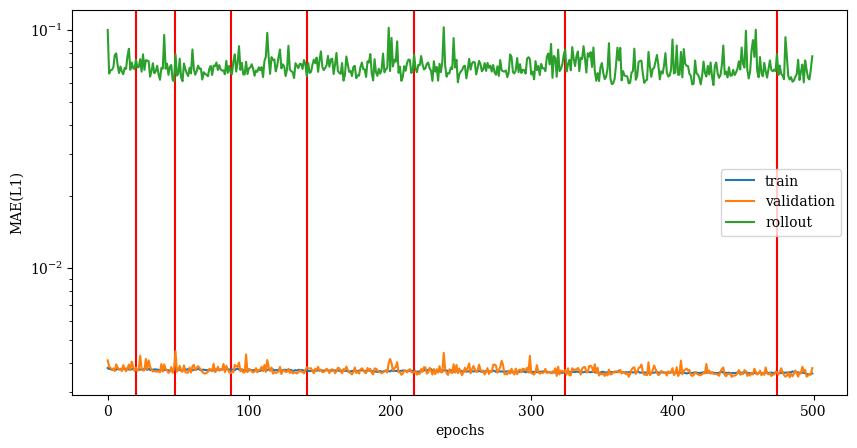

In [3]:
# Plot train history
fig, ax = plt.subplots(figsize=(10, 5))

schedular = get_scheduler(hp.scheduler)
for cycle in schedular.get_updated_epochs(hp.scheduler, len(train_mae)):
    plt.axvline(cycle, color="r")

ax.plot(train_mae, label="train")
ax.plot(val_mae, label="validation")
ax.plot(rollout_mae, label="rollout")
ax.set_xlabel("epochs")
ax.set_ylabel("MAE(L1)")
ax.set_yscale("log")
ax.legend()

fig.show()

In [5]:
approximator = RosslerApproximator.from_hp(hp.approximator)
approximator.load_state_dict(prune_state_dict(checkpoint["best_model_state_dict"]))
# model = RungeKutta(approximator, butcher_tableau=hp.rk).to(device)
model = RungeKutta(approximator, butcher_tableau="rk4").to(device)

rossler_rollout = functools.partial(
    rollout,
    model=model,
    use_amp=hp.amp,
    device=device,
    is_diverging=IsDivergingPrecise(),
)


# Rollout

In [6]:
pred_trajectories: list[npt.NDArray[np.float32]] = []
for idx in trange(len(test_df)):
    pred_trajectories.append(rossler_rollout(series=test_df.iloc[idx]).cpu().numpy())

  0%|          | 0/40 [00:00<?, ?it/s]

In [3]:
# with open(result_dir / f"pred_{test_id}.pkl", "wb") as f:
#     pickle.dump(pred_trajectories, f)

with open(result_dir / f"pred_{test_id}.pkl", "rb") as f:
    pred_trajectories = pickle.load(f)

# Analyze

In [5]:
maes = []
for idx, (true, pred) in enumerate(zip(true_trajectories, pred_trajectories)):
    print(f"{idx=}, {test_df.network_type[idx]}, N={true.shape[1]}", end=" ")
    maes.append(compare_trajectory(true, pred))
maes = np.stack(maes, axis=0)  # (# of samples, S)
print(f"Error: MAE={np.mean(maes):.4e} \t std={np.std(maes):.4e}")

idx=0, rr, N=130 MAE: 0.0139, Maximum err: 0.1164 at step=1948, node=21, coordinate=x
idx=1, rr, N=64 MAE: 0.0749, Maximum err: 3.5179 at step=1619, node=54, coordinate=z
idx=2, rr, N=109 MAE: 0.0657, Maximum err: 5.3342 at step=1902, node=40, coordinate=z
idx=3, er, N=80 MAE: 0.0194, Maximum err: 4.6513 at step=2000, node=30, coordinate=x
idx=4, er, N=121 MAE: 0.0353, Maximum err: 2.9323 at step=1949, node=111, coordinate=z
idx=5, ba, N=104 MAE: 0.3904, Maximum err: 15.5295 at step=1874, node=85, coordinate=y
idx=6, ba, N=123 MAE: 0.0528, Maximum err: 4.0848 at step=1995, node=96, coordinate=z
idx=7, er, N=69 MAE: 0.0596, Maximum err: 13.9994 at step=1896, node=15, coordinate=z
idx=8, er, N=123 MAE: 0.0406, Maximum err: 3.6169 at step=1999, node=98, coordinate=z
idx=9, er, N=83 MAE: 0.1499, Maximum err: 33.6035 at step=1999, node=76, coordinate=z
idx=10, ba, N=56 MAE: 0.2783, Maximum err: 30.8131 at step=1723, node=18, coordinate=z
idx=11, rr, N=87 MAE: 0.0065, Maximum err: 0.1018 at 

## Single sample

In [5]:
sample_idx = 19

print(test_df.network_type[sample_idx])
xticks = np.round(np.linspace(0, times[sample_idx, -1], 5), 2)
time = times[sample_idx]
true_trajcetory = true_trajectories[sample_idx]
pred_trajectory = pred_trajectories[sample_idx]
error = true_trajcetory - pred_trajectory
percentage_error = error / true_trajcetory

print(f"{error[..., 0].min():.2e} < error_x < {error[..., 0].max():.2e}")
print(f"{error[..., 1].min():.2e} < error_y < {error[..., 1].max():.2e}")
print(f"{error[..., 2].min():.2e} < error_z < {error[..., 2].max():.2e}")


ba
-1.56e-01 < error_x < 1.50e-01
-1.65e-01 < error_y < 1.50e-01
-1.61e-01 < error_z < 1.65e-01


plot node with index: [102  47  95  80  23]


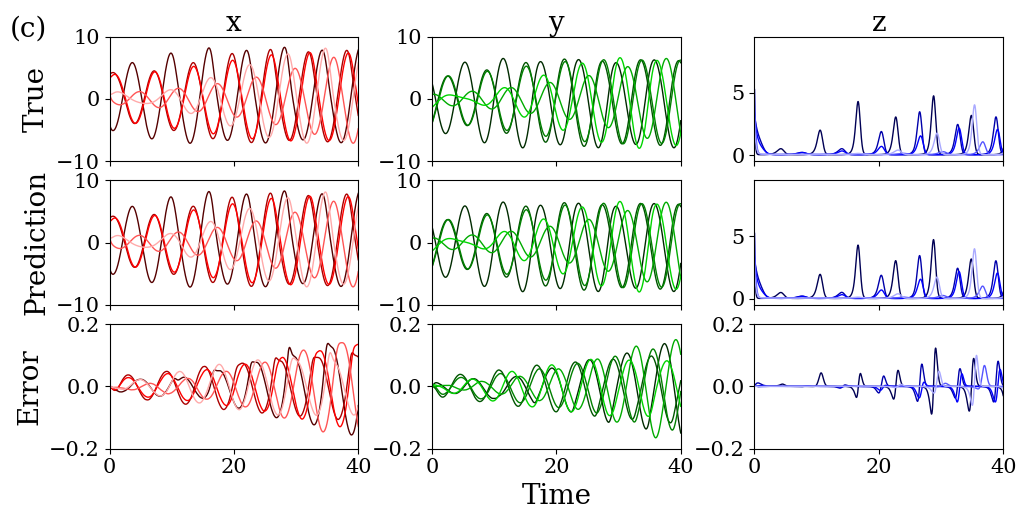

In [16]:
nodes = np.random.choice(np.arange(true_trajcetory.shape[1]), 5, replace=False)
nodes = []
for idx in np.argsort(np.abs(error).sum(axis=0).flatten())[::-1]:  # max
    # for idx in np.argsort(np.abs(error).sum(axis=0).flatten()):    # min
    idx = np.unravel_index(idx, error.shape[1:])
    if idx[0] not in nodes:
        nodes.append(idx[0])
    if len(nodes) == 5:
        break
nodes = np.array(nodes, dtype=np.int64)
print(f"plot node with index: {nodes}")

fig, ((ax00, ax01, ax02), (ax10, ax11, ax12), (ax20, ax21, ax22)) = plt.subplots(
    figsize=(10, 5), nrows=3, ncols=3, sharex=True
)

plot(ax00, ax01, ax02, true_trajcetory, nodes=nodes, time=time, linewidth=1)
ax00.set_ylabel("True", fontsize=20)
ax01.set_ylabel("")
ax02.set_ylabel("")
ax00.set_xlabel("x", fontsize=20)
ax01.set_xlabel("y", fontsize=20)
ax02.set_xlabel("z", fontsize=20)
ax00.xaxis.set_label_position("top")
ax01.xaxis.set_label_position("top")
ax02.xaxis.set_label_position("top")
ax00.set_ylim(-10.0, 10.0)
ax01.set_ylim(-10.0, 10.0)
ax02.set_ylim(-0.5, 9.5)
ax00.tick_params(axis="both", labelsize=15)
ax01.tick_params(axis="both", labelsize=15)
ax02.tick_params(axis="both", labelsize=15)

plot(ax10, ax11, ax12, pred_trajectory, nodes=nodes, time=time, linewidth=1)
ax10.set_ylabel("Prediction", fontsize=20)
ax11.set_ylabel("")
ax12.set_ylabel("")
ax10.set_ylim(-10.0, 10.0)
ax11.set_ylim(-10.0, 10.0)
ax12.set_ylim(-0.5, 9.5)
ax10.tick_params(axis="both", labelsize=15)
ax11.tick_params(axis="both", labelsize=15)
ax12.tick_params(axis="both", labelsize=15)

plot(ax20, ax21, ax22, error, nodes=nodes, time=time, linewidth=1)
ax20.set_ylabel("Error", fontsize=20)
ax21.set_ylabel("")
ax22.set_ylabel("")

ax20.set_ylim(-0.2, 0.2)
ax21.set_ylim(-0.2, 0.2)
ax22.set_ylim(-0.2, 0.2)
ax20.tick_params(axis="both", labelsize=15)
ax21.tick_params(axis="both", labelsize=15)
ax22.tick_params(axis="both", labelsize=15)
ax20.set_xlim(0.0, 40.0)
ax21.set_xlim(0.0, 40.0)
ax22.set_xlim(0.0, 40.0)
ax20.set_xticks([0.0, 20.0, 40.0])
ax21.set_xticks([0.0, 20.0, 40.0])
ax22.set_xticks([0.0, 20.0, 40.0])


ax21.set_xlabel("Time", fontsize=20)
ax00.text(-0.4, 1.0, "(c)", transform=ax00.transAxes, fontsize=20)

fig.tight_layout(pad=0.0)
# fig.savefig(
#     f"{FIG_DIR}/rossler_{test_id}_{sample_idx}_{exp_id}.pdf",
#     bbox_inches="tight",
#     pad_inches=0.0,
# )
fig.show()

x slope: 3.5703e-02 pm 1.2579e-02
x slope of averaged curve: 3.3010e-02
y slope: 3.5402e-02 pm 1.2594e-02
y slope of averaged curve: 3.3584e-02
z slope: 4.3479e-02 pm 1.2275e-02
z slope of averaged curve: 3.8042e-02


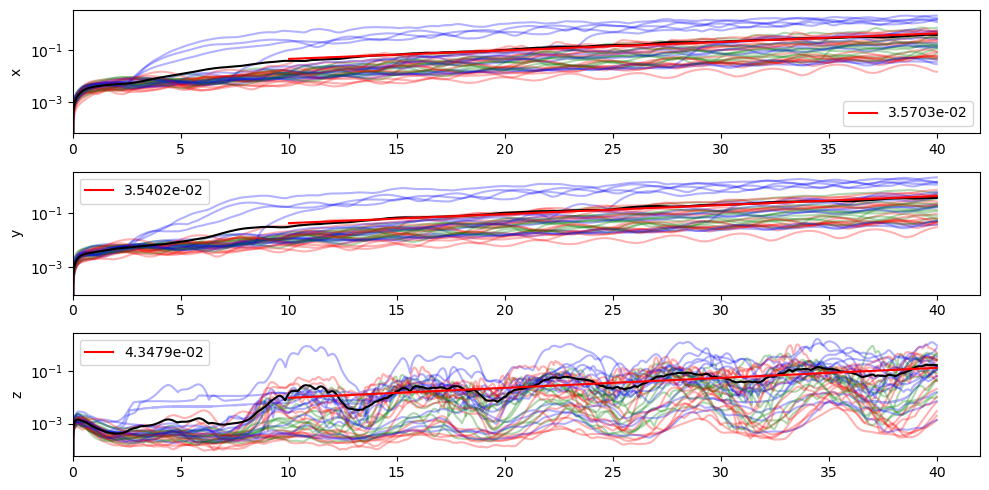

In [17]:
colors = {"rr": "r", "er": "g", "ba": "b"}
fit_range, yscale = 10.0, "log"

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 5), nrows=3)

slopes1, slopes2, slopes3 = [], [], []
for network_type, sample_time, sample_mae in zip(test_df.network_type, times, maes):
    color = colors[network_type]
    plot(
        # ax1, ax2, ax3, sample_mae[:, None, :], time=sample_time, alpha=0.3, color="gray"
        ax1, ax2, ax3, sample_mae[:, None, :], time=sample_time, alpha=0.3, color=color
    )

    mask = sample_time > fit_range
    if yscale == "log":
        *_, slope1, _ = fitting.lin_log_fit(sample_time[mask], sample_mae[mask, 0])
        *_, slope2, _ = fitting.lin_log_fit(sample_time[mask], sample_mae[mask, 1])
        *_, slope3, _ = fitting.lin_log_fit(sample_time[mask], sample_mae[mask, 2])
    else:
        *_, slope1, _ = fitting.lin_fit(sample_time[mask], sample_mae[mask, 0])
        *_, slope2, _ = fitting.lin_fit(sample_time[mask], sample_mae[mask, 1])
        *_, slope3, _ = fitting.lin_fit(sample_time[mask], sample_mae[mask, 2])
    slopes1.append(slope1)
    slopes2.append(slope2)
    slopes3.append(slope3)

final_mae = np.mean(maes, 0)
t = np.linspace(0.0, np.mean(times[:, -1]), times.shape[1], dtype=np.float32)
plot(ax1, ax2, ax3, final_mae[:, None, :], time=t, color="k")

mask = t > fit_range
if yscale == "log":
    fit_t1, fit_mae1, slope1, _ = fitting.lin_log_fit(t[mask], final_mae[mask, 0])
    fit_t2, fit_mae2, slope2, _ = fitting.lin_log_fit(t[mask], final_mae[mask, 1])
    fit_t3, fit_mae3, slope3, _ = fitting.lin_log_fit(t[mask], final_mae[mask, 2])
else:
    fit_t1, fit_mae1, slope1, _ = fitting.lin_fit(t[mask], final_mae[mask, 0])
    fit_t2, fit_mae2, slope2, _ = fitting.lin_fit(t[mask], final_mae[mask, 1])
    fit_t3, fit_mae3, slope3, _ = fitting.lin_fit(t[mask], final_mae[mask, 2])
ax1.plot(fit_t1, fit_mae1, "r-", label=f"{np.mean(slopes1):.4e}")
ax2.plot(fit_t2, fit_mae2, "r-", label=f"{np.mean(slopes2):.4e}")
ax3.plot(fit_t3, fit_mae3, "r-", label=f"{np.mean(slopes3):.4e}")

print(f"x slope: {np.mean(slopes1):.4e} pm {np.std(slopes1):.4e}")
print(f"x slope of averaged curve: {slope1:.4e}")
ax1.legend()
ax1.set_xlim(left=0.0)

print(f"y slope: {np.mean(slopes2):.4e} pm {np.std(slopes2):.4e}")
print(f"y slope of averaged curve: {slope2:.4e}")
ax2.legend()
ax2.set_xlim(left=0.0)

print(f"z slope: {np.mean(slopes3):.4e} pm {np.std(slopes3):.4e}")
print(f"z slope of averaged curve: {slope3:.4e}")
ax3.legend()
ax3.set_xlim(left=0.0)

if yscale == "log":
    ax1.set_yscale("log")
    ax2.set_yscale("log")
    ax3.set_yscale("log")

fig.tight_layout()
# fig.savefig(f"{FIG_DIR}/rossler_xyz_mae.pdf", bbox_inches="tight", pad_inches=0.0)
fig.show()

slope: 3.3266e-02 pm 1.2745e-02
slope of averaged curve: 3.0887e-02


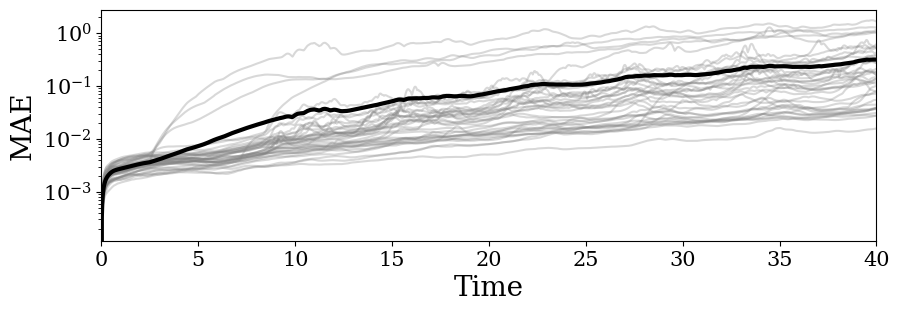

In [25]:
colors = {"rr": "r", "er": "g", "ba": "b"}
fit_range, yscale = 15.0, "log"

fig, ax = plt.subplots(figsize=(10, 3))

slopes = []
for network_type, sample_time, sample_mae in zip(
    test_df.network_type, times, np.mean(maes, -1)
):
    ax.plot(sample_time, sample_mae, alpha=0.3, color="gray")
    # ax.plot(sample_time, sample_mae, alpha=0.3, color=colors[network_type])

    mask = sample_time > fit_range
    if yscale == "log":
        *_, slope, _ = fitting.lin_log_fit(sample_time[mask], sample_mae[mask])
    else:
        *_, slope, _ = fitting.lin_fit(sample_time[mask], sample_mae[mask])
    slopes.append(slope)

final_mae = np.mean(maes, (0, 2))
t = np.linspace(0.0, np.mean(times[:, -1]), times.shape[1], dtype=np.float32)
ax.plot(t, final_mae, "k-", linewidth=3)

mask = t > fit_range
if yscale == "log":
    fit_t, fit_mae, slope, _ = fitting.lin_log_fit(t[mask], final_mae[mask])
else:
    fit_t, fit_mae, slope, _ = fitting.lin_fit(t[mask], final_mae[mask])
print(f"slope: {np.mean(slopes):.4e} pm {np.std(slopes):.4e}")
print(f"slope of averaged curve: {slope:.4e}")
# ax.plot(fit_t, fit_mae, "r-", label=f"{np.mean(slopes):.4f}")
# ax.legend()

if yscale == "log":
    ax.set_yscale("log")
ax.set_xlim(left=0)
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel("MAE", fontsize=20)
ax.tick_params(axis="both", labelsize=15)
ax.set_xlim(0.0, 40.0)

# fig.savefig(
#     f"{FIG_DIR}/rossler_mae_{test_id}_{exp_id}.pdf", bbox_inches="tight", pad_inches=0.0
# )
fig.show()

# Order difference

In [18]:
df1 = pd.read_pickle(DATA_DIR / "rossler_O1.pkl")
pred_trajectories = [traj.numpy() for traj in df1.trajectories]
df4 = pd.read_pickle(DATA_DIR / "rossler_O4.pkl")
true_trajectories = [traj.numpy() for traj in df4.trajectories]
maes = [compare_trajectory(true, pred) for true, pred in zip(pred_trajectories, true_trajectories)]
times = [np.append(0, np.cumsum(dt.numpy())) for dt in df1.dts]


FileNotFoundError: [Errno 2] No such file or directory: '/pds/pds11/hoyun/neural_rk/data/rossler_O1.pkl'

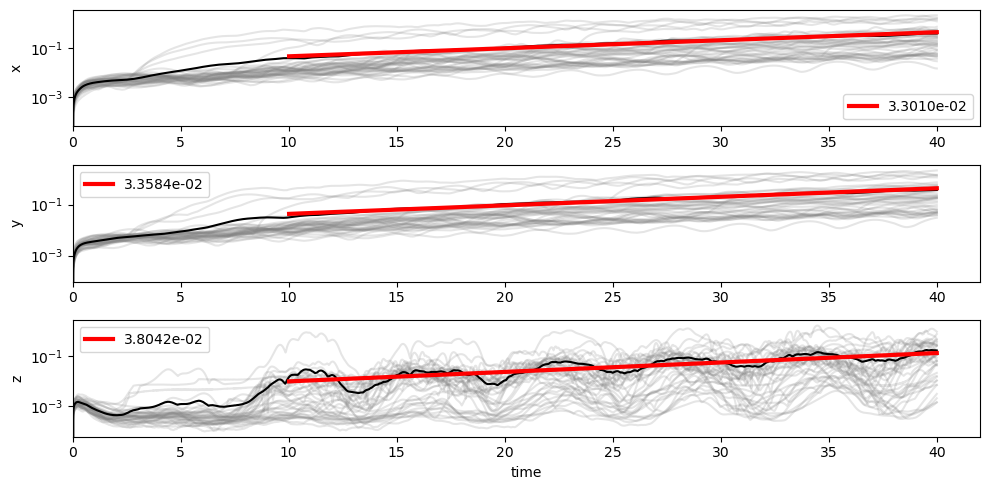

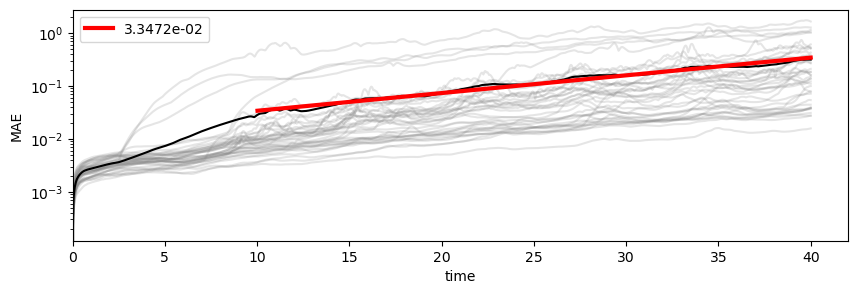

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 5), nrows=3)

for sample_time, sample_mae in zip(times, maes):
    plot(ax1, ax2, ax3, sample_mae[:, None, :], time=sample_time, alpha=0.2, color="gray")


t = np.linspace(0.0, sum(t[-1] for t in times) / len(times), len(times[0]), dtype=np.float32)
mask = t > 10.0
final_mae = np.mean(maes, axis=0)
plot(ax1, ax2, ax3, final_mae[:, None, :], time=t, color="k")

fit_t1, fit_mae1, slope1, _ = fitting.lin_log_fit(t[mask], final_mae[mask, 0])
ax1.plot(fit_t1, fit_mae1, color="red", label=f"{slope1:.4e}", linewidth=3)
ax1.legend()
ax1.set_yscale("log")
ax1.set_xlim(left=0.0)

fit_t2, fit_mae2, slope2, _ = fitting.lin_log_fit(t[mask], final_mae[mask, 1])
ax2.plot(fit_t2, fit_mae2, color="red", label=f"{slope2:.4e}", linewidth=3)
ax2.legend()
ax2.set_yscale("log")
ax2.set_xlim(left=0.0)

fit_t3, fit_mae3, slope3, _ = fitting.lin_log_fit(t[mask], final_mae[mask, 2])
ax3.plot(fit_t3, fit_mae3, color="red", label=f"{slope3:.4e}", linewidth=3)
ax3.legend()
ax3.set_yscale("log")
ax3.set_xlabel("time")
ax3.set_xlim(left=0.0)

fig.tight_layout()
fig.show()


fig, ax = plt.subplots(figsize=(10, 3))

for sample_time, sample_mae in zip(times, np.mean(maes, -1)):
    ax.plot(sample_time, sample_mae, alpha=0.2, color="gray")

t = np.linspace(0.0, sum(t[-1] for t in times) / len(times), len(times[0]), dtype=np.float32)
mask = t > 10.0
final_mae = np.mean(maes, axis=(0, 2))
ax.plot(t, final_mae, "k-")

fit_t, fit_mae, slope, _ = fitting.lin_log_fit(t[mask], final_mae[mask])
ax.plot(fit_t, fit_mae, color="red", label=f"{slope:.4e}", linewidth=3)
ax.legend()
ax.set_yscale("log")
ax.set_xlim(left=0)
ax.set_xlabel("time")
ax.set_ylabel("MAE")

fig.show()